In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.linalg import lstsq
import os
import pandas as pd

In [2]:
SSAS=2.0
V=48
Filter="Al"
nameS="DataSimulation"
nameR="Im"+str(SSAS)
nameFV=Filter+str(V)
nameT="Ph2"
nameFF="FF"
nameH="ImE.txt"
nameRAW0=nameS+"/"+nameR+"/"+nameFV+"/"+nameT
nameFF0=nameS+"/"+nameR+"/"+nameFV+"/"+nameFF

In [3]:
nameE1=14
nameE2=20
nameE3=21
nameE4=35
nameE5=38
nameE6=47
Step1=2
Step2=1
Step3=3
E11=np.arange(nameE1,nameE2+1,Step1)
E12=np.arange(nameE3,nameE4+1,Step2)
E13=np.arange(nameE5,nameE6+1,Step3)
E14=np.arange(nameE3,V+1,Step2)
E15=np.arange(nameE5,V+1,Step3)
#E=np.concatenate((E11,E14)) #Al28, Rh28
#E=np.concatenate((E11,E12,E15)) #Al38
E=np.concatenate((E11,E12,E13)) #Al48
W=55*(10**(-6))
Npixeles=61

In [4]:
name1="MaterialesS/AluminaM.txt"
name2="MaterialesS/HAM.txt"
name3="MaterialesS/Breast50-50M.txt"
name4="MaterialesS/SiliconeM.txt"
name5="MaterialesS/AireM.txt"
MaterialAlumina = np.genfromtxt(name1)
MaterialHA = np.genfromtxt(name2)
MaterialBreast = np.genfromtxt(name3)
MaterialSilicone = np.genfromtxt(name4)
MaterialAire = np.genfromtxt(name5)

In [5]:
#Material1=MaterialAlumina-MaterialBreast
#nameMaterial1="Al"
#Material1=MaterialHA-MaterialBreast
#nameMaterial1="HA"
Material1=MaterialAire
nameMaterial1="A"
Material2=MaterialSilicone



In [6]:
N1=(0.85E+6)
N2=(1.1E+6)
name11="MaterialesS/"+Filter+"-"+str(V)+"kV.txt"
MaterialSpectrum = np.genfromtxt(name11)
MaterialSpectrumN1=(MaterialSpectrum/sum(MaterialSpectrum))*N1
MaterialSpectrumN2=(MaterialSpectrum/sum(MaterialSpectrum))*N2

In [7]:
def IP(name):
    f=-np.log(name)
    return f

In [8]:
def TE2(E,Material1,Material2,m):
    Q=[Material1[E[m]-1],Material2[E[m]-1]]
    return Q

In [9]:
def TE3(E,Material1,Material2,Material3,m):
    Q=[Material1[E[m]-1],Material2[E[m]-1],Material3[E[m]-1]]
    return Q

In [10]:
def BL(name1,name2,Material1,Material2,E,m):
    Ab1=-Material1[E[m]-1]*name1-Material2[E[m]-1]*name2
    Ab2=np.exp(Ab1)
    return Ab1,Ab2

In [11]:
def FFC(IM, FF, u):
    FFC=np.rot90(IM/FF,u)
    maxIM = 0
    for i in range(len(IM)):
        for j in range(len(IM)):
            if (FFC[i,j] > maxIM and  not np.isinf(FFC[i,j])):
                maxIM = FFC[i,j]
            if (np.isnan( FFC[i,j] ) or np.isinf(-FFC[i,j])):
                FFC[i,j] = 0
    return FFC

In [12]:
def PI(name,inicial,final,h,y):
    P=np.zeros(y-h)
    for i in range(inicial,final):
        P=P+name[i,h:y]
    mean=P/(final-inicial)
    return mean

In [13]:
def square(name,SQ,X,Y):
    I=name.copy()
    Square = np.zeros((SQ,SQ))
    SX=X-SQ//2
    SY=Y-SQ//2
    I[SY:SY+SQ,SX:SX+SQ] = Square
    return I

In [14]:
def SEG(name):
    B=[]
    for i in range(len(name)):
        for j in range(len(name)):
            if name[i,j]!=0:
                B.append(name[i,j])

    B_A=np.mean(B)
    B_DA=np.array(B)
    B_DE=B_DA.std()
    return B_A,B_DE

In [15]:
def SDR(name,SQ,Step,X,Yi,Yf):
    T=name.copy()
    for j in range(Yi,Yf+Step,Step):
        T=square(T,SQ,X,j)
    Signal=name-T
    SD=SEG(Signal)[0]
    DS=SEG(Signal)[1]
    return Signal,T,SD,DS

In [16]:
def CNR(S_p,B_A,B_DE):
    CNR_0=(np.abs(S_p-B_A))/B_DE
    return CNR_0

In [17]:
def CNRE(N,materialTissue,materialCalc,materialSilicone,t_Tissue,t_Silicone,t_Calc,Ei):
    CNR=[]
    M1=t_Calc*((10)**(-6))
    M2=t_Tissue*((10)**(-2))
    M3=t_Silicone*((10)**(-2))
    for i in range(len(Ei)):
        C=np.sqrt(N[i]*np.exp(-materialTissue[Ei[i]-1]*M2-materialSilicone[Ei[i]-1]*M3))*np.abs(1-np.exp((materialTissue[Ei[i]-1]-materialCalc[Ei[i]-1])*M1))
        CNR.append(C)
    return CNR

In [18]:
def CNRMax(name1,E):
    S=[]
    for i in range(len(name1)):
        P=name1[i]
        if (P==np.max(name1)):
            S.append(i+1)
    k=E[S[0]-1]
    return k,S[0]

In [19]:
t_Calc=445.5 #um
t_Tissue=5 #cm
CNRAlSpectrum=CNRE(MaterialSpectrumN1,MaterialBreast,MaterialAlumina,MaterialSilicone,t_Tissue,0,t_Calc,E)
CNRAlISpectrum=CNRE(MaterialSpectrumN2,MaterialBreast,MaterialAlumina,MaterialSilicone,t_Tissue,SSAS,t_Calc,E)
CNRHASpectrum=CNRE(MaterialSpectrumN1,MaterialBreast,MaterialHA,MaterialSilicone,t_Tissue,0,t_Calc,E)
CNRHAISpectrum=CNRE(MaterialSpectrumN2,MaterialBreast,MaterialHA,MaterialSilicone,t_Tissue,SSAS,t_Calc,E)

In [20]:
I=[]
for i in range(len(E)):
    RAW=np.genfromtxt(nameRAW0+"_{}__".format(E[i])+nameH)
    FF=np.genfromtxt(nameFF0+"_{}__".format(E[i])+nameH)
    I.append(FFC(RAW, FF, 0))

C:\Users\USER\AppData\Local\Temp\ipykernel_9892\3278609898.py:2: RuntimeWarning: divide by zero encountered in divide
  FFC=np.rot90(IM/FF,u)


In [21]:
IU=[]    
for i in range(len(E)):
    G=IP(I[i])
    IU.append(G)

C:\Users\USER\AppData\Local\Temp\ipykernel_9892\99105815.py:2: RuntimeWarning: divide by zero encountered in log
  f=-np.log(name)


In [22]:
Ni=3  
#Nf=len(E)-4 #Rh28:0.5,1.0,1.5,2.0
#Nf=len(E)-2 #Al28:0.5
#Nf=len(E) #Al28:1.0,1.5,2.0
#Nf=len(E)-4 #Al38:0.5
#Nf=len(E)-1 #Al38:1.0,1.5
#Nf=len(E) #Al38:2.0
#Nf=len(E)-5 #Al48:0.5
#Nf=len(E)-3 #Al48:1.0
Nf=len(E)-1 #Al48:1.5,2.0
Step=1
Etest=[]
for a in range(Ni,Nf,Step):
    Etest.append(E[a])
print(Etest)

[np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(38), np.int64(41), np.int64(44)]


In [23]:
MI=[]
for j in range(Npixeles):
    SS=[]
    for i in range(Npixeles):    
        SSF=[]
        for a in range(Ni,Nf,Step):
            SSF.append([IU[a][j][i]])
        SS.append(SSF)
    MI.append(np.array(SS))

In [24]:
MA=[]
for a in range(Ni,Nf,Step):
    MA.append(TE2(E,Material1,Material2,a))
MA=np.array(MA)

In [25]:
Esp_Material1=np.zeros((Npixeles,Npixeles))
Esp_Material2=np.zeros((Npixeles,Npixeles))

In [26]:
for j in range(Npixeles):
    for i in range(Npixeles):
        Mt, Mresiduals, Mrank, Ms = lstsq(MA, MI[i][j])
        Esp_Material1[i,j]=Mt[0]
        Esp_Material2[i,j]=Mt[1]

C:\Users\USER\AppData\Local\Temp\ipykernel_9892\3074531011.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Esp_Material1[i,j]=Mt[0]
C:\Users\USER\AppData\Local\Temp\ipykernel_9892\3074531011.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Esp_Material2[i,j]=Mt[1]


In [27]:
PIEsM1=PI(Esp_Material1,0,Npixeles,0,Npixeles)
PIEsM2=PI(Esp_Material2,0,Npixeles,0,Npixeles)

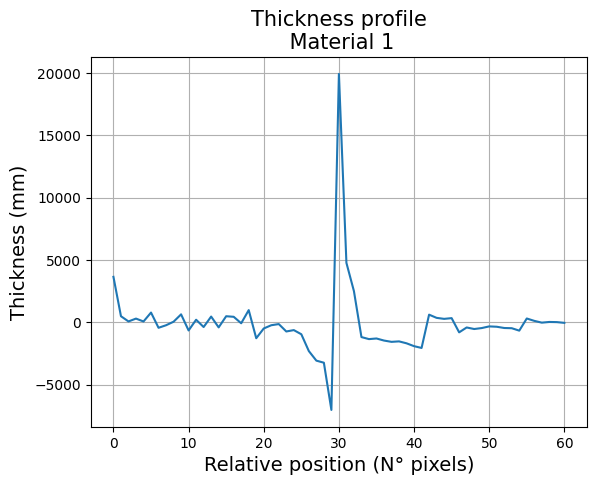

In [28]:
JH=0.1
fig,ax=plt.subplots()
plt.plot(PIEsM1*1000+JH,label="Simulation")
plt.title("Thickness profile\n Material 1",fontsize=15)
plt.ylabel("Thickness (mm)",fontsize=14)
plt.xlabel("Relative position (N° pixels)",fontsize=14)
plt.grid()

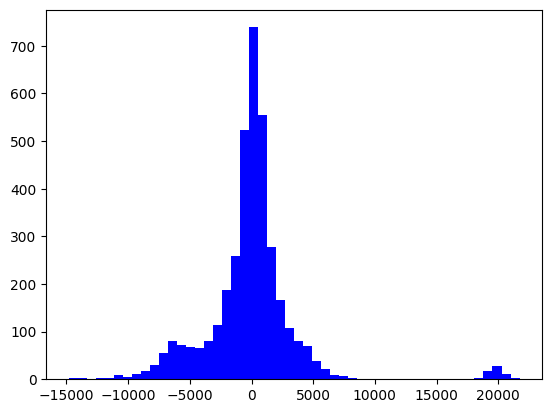

In [29]:
Th1=plt.hist(np.ravel(Esp_Material1*1000+JH),bins=50,color="blue")

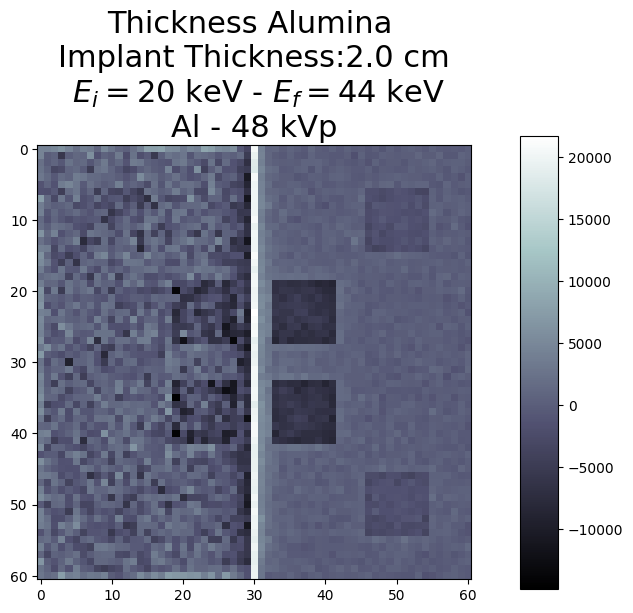

In [30]:
fig, ax = plt.subplots(figsize=(7, 7))
u=ax.imshow(Esp_Material1*1000+JH, cmap="bone")
plt.title("Thickness Alumina \nImplant Thickness:"+str(SSAS)+" cm\n $E_{i}=$"+str(np.min(Etest))+" keV - $E_{f}=$"+str(np.max(Etest))+" keV\n"+Filter+" - "+str(V)+" kVp", fontsize=22)
fig.colorbar(u,ax=ax,location='right', anchor=(0.5, 0.5), shrink=0.84,aspect=12)

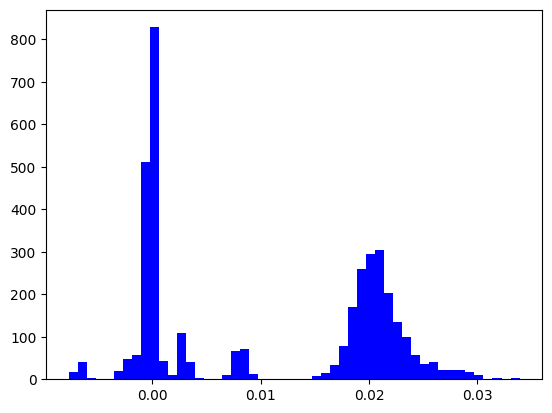

In [31]:
Th2=plt.hist(np.ravel(Esp_Material2),bins=50,color="blue")

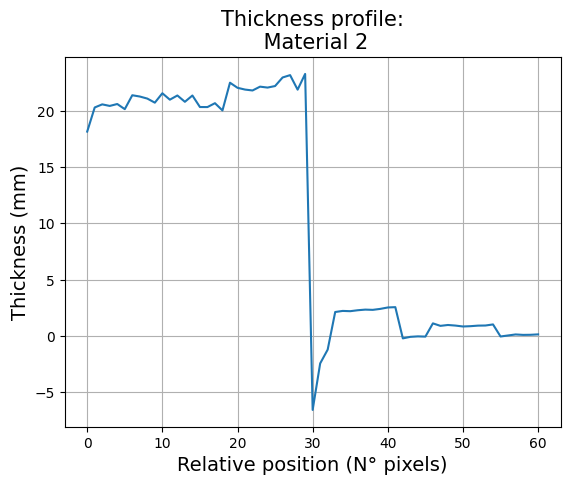

In [32]:
JJ=0.1
fig,ax=plt.subplots()
plt.plot(PIEsM2*1000+JJ,label="Simulation")
plt.title("Thickness profile:\n Material 2",fontsize=15)
plt.ylabel("Thickness (mm)",fontsize=14)
plt.xlabel("Relative position (N° pixels)",fontsize=14)
plt.grid()

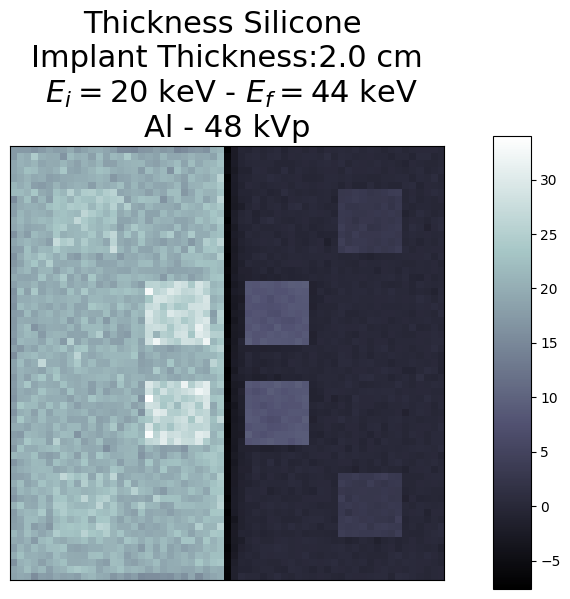

In [33]:
fig, ax = plt.subplots(figsize=(7, 7))
u=ax.imshow(Esp_Material2*1000+JJ, cmap="bone")
plt.title("Thickness Silicone \nImplant Thickness:"+str(SSAS)+" cm\n $E_{i}=$"+str(np.min(Etest))+" keV - $E_{f}=$"+str(np.max(Etest))+" keV\n"+Filter+" - "+str(V)+" kVp", fontsize=22)
plt.xticks([])
plt.yticks([])
fig.colorbar(u,ax=ax,location='right', anchor=(0.5, 0.5), shrink=0.84,aspect=12)

In [34]:
print("CNR of HA (Thickness Material 1) =",np.round(CNR(SDR(Esp_Material1,9,14,37,23,37)[2],SDR(Esp_Material1,9,14,50,23,37)[2],SDR(Esp_Material1,9,14,50,23,37)[3]),3))
print("CNR of Al2O3 (Thickness Material 1) =",np.round(CNR(SDR(Esp_Material1,9,40,50,10,50)[2],SDR(Esp_Material1,9,14,50,23,37)[2],SDR(Esp_Material1,9,14,50,23,37)[3]),3))
print("CNR of HA (Thickness Material 1) =",np.round(CNR(SDR(Esp_Material1,9,14,23,23,37)[2],SDR(Esp_Material1,9,14,10,23,37)[2],SDR(Esp_Material1,9,14,10,23,37)[3]),3))
print("CNR of Al2O3 (Thickness Material 1) =",np.round(CNR(SDR(Esp_Material1,9,40,10,10,50)[2],SDR(Esp_Material1,9,40,23,10,50)[2],SDR(Esp_Material1,9,40,23,10,50)[3]),3))

CNR of HA (Thickness Material 1) = 12.204
CNR of Al2O3 (Thickness Material 1) = 3.55
CNR of HA (Thickness Material 1) = 2.132
CNR of Al2O3 (Thickness Material 1) = 0.4


In [35]:
print("CNR of HA (Thickness Material 2) =",np.round(CNR(SDR(Esp_Material2,9,14,37,23,37)[2],SDR(Esp_Material2,9,14,50,23,37)[2],SDR(Esp_Material2,9,14,50,23,37)[3]),3))
print("CNR of Al2O3 (Thickness Material 2) =",np.round(CNR(SDR(Esp_Material2,9,40,50,10,50)[2],SDR(Esp_Material2,9,14,50,23,37)[2],SDR(Esp_Material2,9,14,50,23,37)[3]),3))
print("CNR of HA (Thickness Material 2) =",np.round(CNR(SDR(Esp_Material2,9,14,23,23,37)[2],SDR(Esp_Material2,9,14,10,23,37)[2],SDR(Esp_Material2,9,14,10,23,37)[3]),3))
print("CNR of Al2O3 (Thickness Material 2) =",np.round(CNR(SDR(Esp_Material2,9,40,10,10,50)[2],SDR(Esp_Material2,9,40,23,10,50)[2],SDR(Esp_Material2,9,40,23,10,50)[3]),3))

CNR of HA (Thickness Material 2) = 24.098
CNR of Al2O3 (Thickness Material 2) = 8.604
CNR of HA (Thickness Material 2) = 4.506
CNR of Al2O3 (Thickness Material 2) = 1.608


In [36]:
II=[]
for i in range(len(E)):
    II.append(BL(Esp_Material1,Esp_Material2,Material1,Material2,E,i)[1])

In [37]:
mm=CNRMax(CNRAlSpectrum,E)[1]-1
m=CNRMax(CNRAlISpectrum,E)[1]-1
print("Energy for No Implant",E[mm])
print("Energy for Implant",E[m])

Energy for No Implant 23
Energy for Implant 29


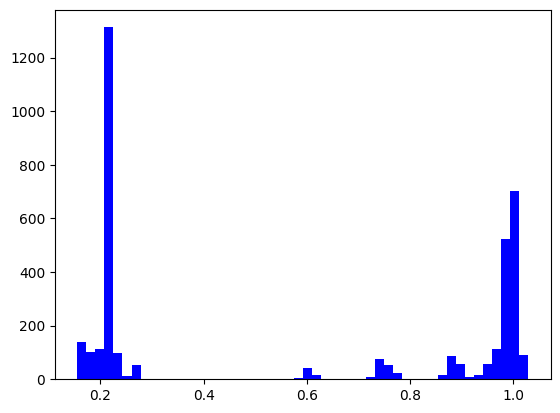

In [38]:
AtenE=plt.hist(np.ravel(I[m]),bins=50,color="blue")

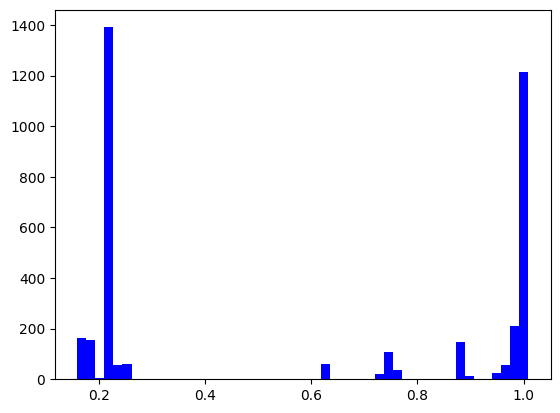

In [39]:
AtenS=plt.hist(np.ravel(II[m]),bins=50,color="blue")

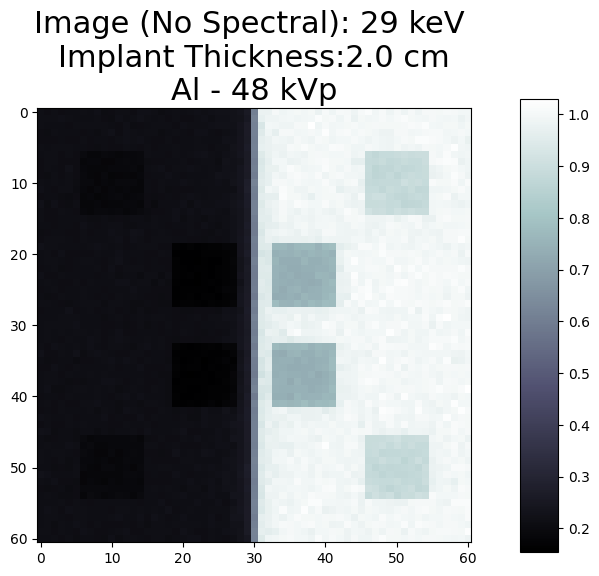

In [40]:
fig, ax = plt.subplots(figsize=(7, 7))
u=ax.imshow(I[m], cmap="bone")
plt.title("Image (No Spectral): "+str(E[m])+" keV \nImplant Thickness:"+str(SSAS)+" cm\n"+Filter+" - "+str(V)+" kVp", fontsize=22)
#plt.xticks([])
#plt.yticks([])
fig.colorbar(u,ax=ax,location='right', anchor=(0.5, 0.5), shrink=0.84,aspect=12)

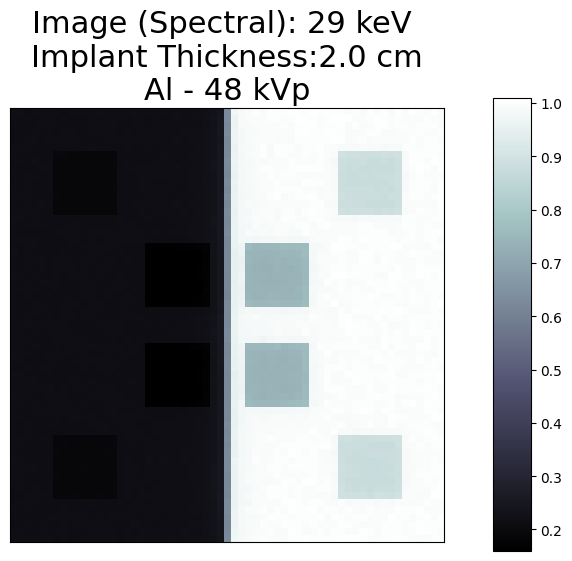

In [41]:
fig, ax = plt.subplots(figsize=(7, 7))
u=ax.imshow(II[m], cmap="bone")
plt.title("Image (Spectral): "+str(E[m])+" keV \nImplant Thickness:"+str(SSAS)+" cm\n"+Filter+" - "+str(V)+" kVp", fontsize=22)
plt.xticks([])
plt.yticks([])
fig.colorbar(u,ax=ax,location='right', anchor=(0.5, 0.5), shrink=0.84,aspect=12)

In [42]:
AtE=PI(I[m],30,38,0,Npixeles)
AtS=PI(II[m],30,38,0,Npixeles)

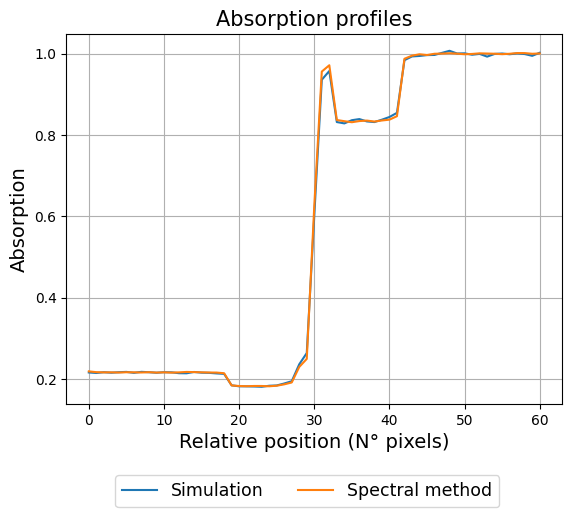

In [43]:
fig,ax=plt.subplots()
plt.plot(AtE,label="Simulation")
plt.plot(AtS,label="Spectral method")
plt.title("Absorption profiles",fontsize=15)
plt.ylabel("Absorption",fontsize=14)
plt.xlabel("Relative position (N° pixels)",fontsize=14)
plt.grid()
#plt.text(210, 0.5, name, fontsize=15)
plt.legend(bbox_to_anchor=(0.89, -0.17),mode = "Expand", ncol=4,fontsize=12.5)

In [44]:
CNRAlNINE=[]
CNRAlNIE=[]
CNRAlINE=[]
CNRAlIE=[]
CNRHANINE=[]
CNRHANIE=[]
CNRHAINE=[]
CNRHAIE=[]
for i in range(len(E)):
    CNRAlNINE.append(CNR(SDR(I[i],9,40,50,10,50)[2],SDR(I[i],9,14,50,23,37)[2],SDR(I[i],9,14,50,23,37)[3]))
    CNRAlNIE.append(CNR(SDR(II[i],9,40,50,10,50)[2],SDR(II[i],9,14,50,23,37)[2],SDR(II[i],9,14,50,23,37)[3]))
    CNRAlINE.append(CNR(SDR(I[i],9,40,10,10,50)[2],SDR(I[i],9,40,23,10,50)[2],SDR(I[i],9,40,23,10,50)[3]))
    CNRAlIE.append(CNR(SDR(II[i],9,40,10,10,50)[2],SDR(II[i],9,40,23,10,50)[2],SDR(II[i],9,40,23,10,50)[3]))
    CNRHANINE.append(CNR(SDR(I[i],9,14,37,23,37)[2],SDR(I[i],9,14,50,23,37)[2],SDR(I[i],9,14,50,23,37)[3]))
    CNRHANIE.append(CNR(SDR(II[i],9,14,37,23,37)[2],SDR(II[i],9,14,50,23,37)[2],SDR(II[i],9,14,50,23,37)[3]))
    CNRHAINE.append(CNR(SDR(I[i],9,14,23,23,37)[2],SDR(I[i],9,14,10,23,37)[2],SDR(I[i],9,14,10,23,37)[3]))
    CNRHAIE.append(CNR(SDR(II[i],9,14,23,23,37)[2],SDR(II[i],9,14,10,23,37)[2],SDR(II[i],9,14,10,23,37)[3]))
CNRAlNINE=np.array(CNRAlNINE)
CNRAlNIE=np.array(CNRAlNIE)
CNRAlINE=np.array(CNRAlINE)
CNRAlIE=np.array(CNRAlIE)
CNRHANINE=np.array(CNRHANINE)
CNRHANIE=np.array(CNRHANIE)
CNRHAINE=np.array(CNRHAINE)
CNRHAIE=np.array(CNRHAIE)

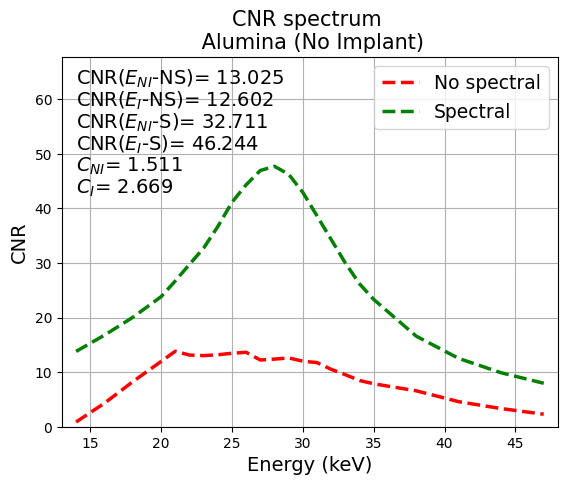

In [76]:
fig,ax=plt.subplots()
plt.plot(E,CNRAlNINE, "--",label="No spectral",linewidth=2.5,color="red")
plt.plot(E,CNRAlNIE, "--",label="Spectral",linewidth=2.5,color="green")
plt.title("CNR spectrum \n Alumina (No Implant)",fontsize=15)
plt.ylabel("CNR",fontsize=14)
plt.xlabel("Energy (keV)",fontsize=14)
plt.grid()
plt.xlim(E[0]-1,E[len(E)-1]+1)
plt.ylim(0,max(CNRAlNIE)+20)
plt.text(E[0], max(CNRAlNIE)+15,'CNR($E_{NI}$-NS)= '+str(np.round(CNRAlNINE[mm],3)), fontsize=14, color='black',rotation=0)
plt.text(E[0], max(CNRAlNIE)+11,'CNR($E_{I}$-NS)= '+str(np.round(CNRAlNINE[m],3)), fontsize=14, color='black',rotation=0)
plt.text(E[0], max(CNRAlNIE)+7,'CNR($E_{NI}$-S)= '+str(np.round(CNRAlNIE[mm],3)), fontsize=14, color='black',rotation=0)
plt.text(E[0], max(CNRAlNIE)+3,'CNR($E_{I}$-S)= '+str(np.round(CNRAlNIE[m],3)), fontsize=14, color='black',rotation=0)
plt.text(E[0], max(CNRAlNIE)-1,"$C_{NI}$= "+str(np.round(CNRAlNIE[mm]/CNRAlNINE[mm]-1,3)), fontsize=14, color='black',rotation=0)
plt.text(E[0], max(CNRAlNIE)-5,"$C_{I}$= "+str(np.round(CNRAlNIE[m]/CNRAlNINE[m]-1,3)), fontsize=14, color='black',rotation=0)
plt.legend(loc=0,mode = "Expand", ncol=1,fontsize=13.5)

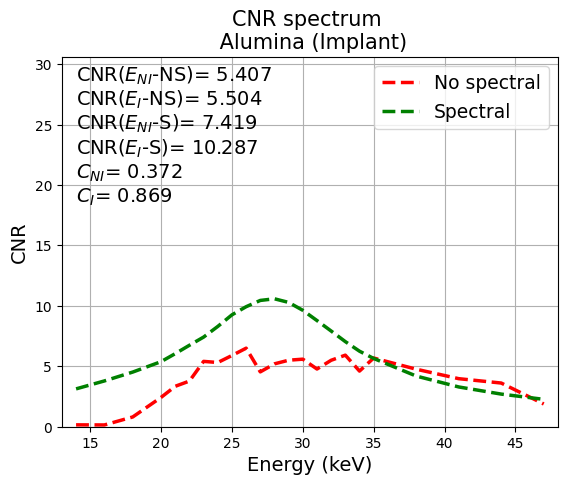

In [ ]:
fig,ax=plt.subplots()
plt.plot(E,CNRAlINE, "--",label="No spectral",linewidth=2.5,color="red")
plt.plot(E,CNRAlIE, "--",label="Spectral",linewidth=2.5,color="green")
plt.title("CNR spectrum \n Alumina (Implant)",fontsize=15)
plt.ylabel("CNR",fontsize=14)
plt.xlabel("Energy (keV)",fontsize=14)
plt.grid()
plt.xlim(E[0]-1,E[len(E)-1]+1)
plt.ylim(0,max(CNRAlIE)+20)
plt.text(E[0], max(CNRAlIE)+18,'CNR($E_{NI}$-NS)= '+str(np.round(CNRAlINE[mm],3)), fontsize=14, color='black',rotation=0)
plt.text(E[0], max(CNRAlIE)+16,'CNR($E_{I}$-NS)= '+str(np.round(CNRAlINE[m],3)), fontsize=14, color='black',rotation=0)
plt.text(E[0], max(CNRAlIE)+14,'CNR($E_{NI}$-S)= '+str(np.round(CNRAlIE[mm],3)), fontsize=14, color='black',rotation=0)
plt.text(E[0], max(CNRAlIE)+12,'CNR($E_{I}$-S)= '+str(np.round(CNRAlIE[m],3)), fontsize=14, color='black',rotation=0)
plt.text(E[0], max(CNRAlIE)+10,"$C_{NI}$= "+str(np.round(CNRAlIE[mm]/CNRAlINE[mm]-1,3)), fontsize=14, color='black',rotation=0)
plt.text(E[0], max(CNRAlIE)+8,"$C_{I}$= "+str(np.round(CNRAlIE[m]/CNRAlINE[m]-1,3)), fontsize=14, color='black',rotation=0)
plt.legend(loc=0,mode = "Expand", ncol=1,fontsize=13.5)

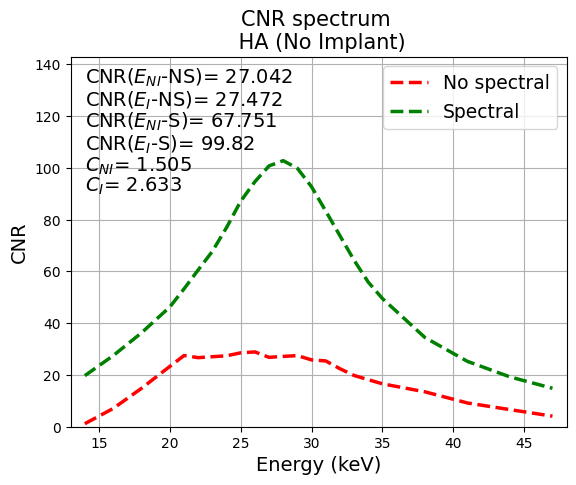

In [77]:
fig,ax=plt.subplots()
plt.plot(E,CNRHANINE, "--",label="No spectral",linewidth=2.5,color="red")
plt.plot(E,CNRHANIE, "--",label="Spectral",linewidth=2.5,color="green")
plt.title("CNR spectrum \n HA (No Implant)",fontsize=15)
plt.ylabel("CNR",fontsize=14)
plt.xlabel("Energy (keV)",fontsize=14)
plt.grid()
plt.xlim(E[0]-1,E[len(E)-1]+1)
plt.ylim(0,max(CNRHANIE)+40)
plt.text(E[0], max(CNRHANIE)+30,'CNR($E_{NI}$-NS)= '+str(np.round(CNRHANINE[mm],3)), fontsize=14, color='black',rotation=0)
plt.text(E[0], max(CNRHANIE)+21,'CNR($E_{I}$-NS)= '+str(np.round(CNRHANINE[m],3)), fontsize=14, color='black',rotation=0)
plt.text(E[0], max(CNRHANIE)+13,'CNR($E_{NI}$-S)= '+str(np.round(CNRHANIE[mm],3)), fontsize=14, color='black',rotation=0)
plt.text(E[0], max(CNRHANIE)+4,'CNR($E_{I}$-S)= '+str(np.round(CNRHANIE[m],3)), fontsize=14, color='black',rotation=0)
plt.text(E[0], max(CNRHANIE)-4,"$C_{NI}$= "+str(np.round(CNRHANIE[mm]/CNRHANINE[mm]-1,3)), fontsize=14, color='black',rotation=0)
plt.text(E[0], max(CNRHANIE)-12,"$C_{I}$= "+str(np.round(CNRHANIE[m]/CNRHANINE[m]-1,3)), fontsize=14, color='black',rotation=0)
plt.legend(loc=0,mode = "Expand", ncol=1,fontsize=13.5)

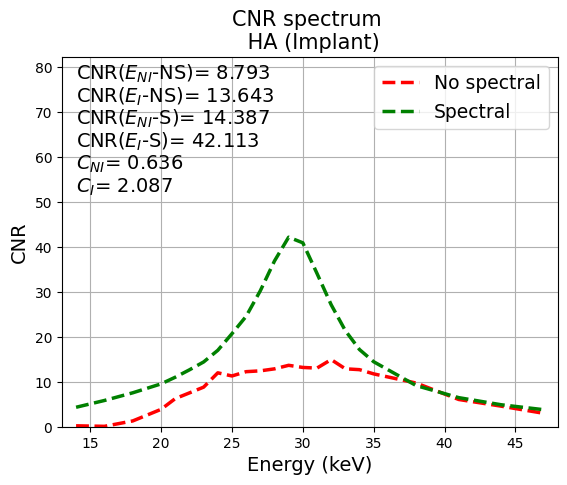

In [78]:
fig,ax=plt.subplots()
plt.plot(E,CNRHAINE, "--",label="No spectral",linewidth=2.5,color="red")
plt.plot(E,CNRHAIE, "--",label="Spectral",linewidth=2.5,color="green")
plt.title("CNR spectrum \n HA (Implant)",fontsize=15)
plt.ylabel("CNR",fontsize=14)
plt.xlabel("Energy (keV)",fontsize=14)
plt.grid()
plt.xlim(E[0]-1,E[len(E)-1]+1)
plt.ylim(0,max(CNRHAIE)+40)
plt.text(E[0], max(CNRHAIE)+35,'CNR($E_{NI}$-NS)= '+str(np.round(CNRHAINE[mm],3)), fontsize=14, color='black',rotation=0)
plt.text(E[0], max(CNRHAIE)+30,'CNR($E_{I}$-NS)= '+str(np.round(CNRHAINE[m],3)), fontsize=14, color='black',rotation=0)
plt.text(E[0], max(CNRHAIE)+25,'CNR($E_{NI}$-S)= '+str(np.round(CNRHAIE[mm],3)), fontsize=14, color='black',rotation=0)
plt.text(E[0], max(CNRHAIE)+20,'CNR($E_{I}$-S)= '+str(np.round(CNRHAIE[m],3)), fontsize=14, color='black',rotation=0)
plt.text(E[0], max(CNRHAIE)+15,"$C_{NI}$= "+str(np.round(CNRHAIE[mm]/CNRHAINE[mm]-1,3)), fontsize=14, color='black',rotation=0)
plt.text(E[0], max(CNRHAIE)+10,"$C_{I}$= "+str(np.round(CNRHAIE[m]/CNRHAINE[m]-1,3)), fontsize=14, color='black',rotation=0)
plt.legend(loc=0,mode = "Expand", ncol=1,fontsize=13.5)